## 1 Загрузка данных

In [534]:
#!g1.1

# for real data

def preprop(filename):
    
    triplets=[]
    
    with open(filename, 'r') as f:
        ff=f.readlines()
        for i in ff[1:]:
            fff=i.split(',')
            triplets.append([fff[0], fff[1], float(fff[4][:-1])])
    
    print(f'Triplets count: {len(triplets)}')
    
    return triplets

In [535]:
#!g1.1

# for syntetic data

def generate_dataset(n=20):
    
    triplets=[]
    
    for i in range(n):
        for j in range(n):
            if i < j:
                triplets.append([i, j, abs(i-j)]) # если поменять на (i-j) то перестаёт сходиться
            
    print(f'Triplets count: {len(triplets)}')
    
    return triplets

In [537]:
#!g1.1

# give quads

# можно кстати добавить зазор прямо сюда( на уровне генератора(хорошая идея кстати))
# лучше разницу на дифф - abs(abs(i-j)-abs(ii-jj))!!!

# when reverse is Flase - more k for more similar objects
# when reverse is True - less k for more similar objects

def prepare_quads(dataset, margin=0, reverse=False):        
    quads = set()
    
    rev_flag = 1
    if reverse:
        rev_flag = -1
    
    for i, j, k in dataset:
        for ii, jj, kk in dataset:
            cur_quad = None
            
            abs_diff = abs(k - kk)
            
            if abs_diff >= margin: # empiric constant (так-то нужно по распределению выбирать)
                # more k for more similar objects (when reverse False)
                # мб из-за этого отрицательная корреляция и была
                if rev_flag * k > rev_flag * kk:
                    cur_quad = tuple(sorted([i, j]) + sorted([ii, jj])) # sorted([5, 4]) = [4, 5] 
                    # если числа из generate_dataset то они уже упорядочены и (в этом случае) можно писать [i, j, ii, jj]
                    # если строки, то получается однозначный порядок - что важно для set'а
                elif rev_flag * k < rev_flag * kk:
                    cur_quad = tuple(sorted([ii, jj]) + sorted([i, j]))
            
            if cur_quad and cur_quad not in quads: # that's why not quads_list
                quads.add(cur_quad)
    
    #quads = list(quads_set)
    print(f'Random sample: {sample(quads, 3)}')
    print(f'Generated quads count : {len(quads)}')
    return quads

In [538]:
#!g1.1

def prepare_index(expert_quads):
    goods_vocab = set()
    goods_index = {}
    counter = 0
    goods_pool_indexed = []

    for i in expert_quads:
        for w in i:
            if w not in goods_vocab:
                goods_vocab.add(w)       # тут всё держится на том, что это добавление последовательное?
                goods_index[w] = counter # видимо нет, потому что основная структура эта
                counter += 1             # так-то в torch есть встроенная структура для этого

        goods_pool_indexed.append([goods_index[i[0]],
                                   goods_index[i[1]],
                                   goods_index[i[2]],
                                   goods_index[i[3]]                               
                                   ])

    print(f'Vocab size: {len(goods_vocab)}')
    #print(len(goods_pool_indexed))
    #print(goods_pool_indexed[-10:])
    return goods_vocab, goods_index, goods_pool_indexed

In [581]:
#!g1.1

# linear example

# может не сразу начинать хорошо сходиться - видимо это из-за инициализации весов - попробуйте запустить несколько раз
# или может размерность 1 очень сложная и попадает в локальный экстремум
# иногда до 10 раз нужно перезапустить

n = 20
syntez = generate_dataset(n)
expert_quads = prepare_quads(syntez, margin=0, reverse=True)
# when reverse False, сходимость плохая

linear_with_index = True
if not linear_with_index: # in easiest example (linear without index) goods_pool_indexed == expert_quads
    print("Linear without index")
    goods_vocab = set(range(n))
    goods_index = {i:i for i in range(n)}
    goods_pool_indexed = expert_quads
else: # in easiest example 2 (linear with index) we need goods_index and goods_pool_indexed (good_vocab also used in hand_checker_2)
    print("Linear with index")
    goods_vocab, goods_index, goods_pool_indexed = prepare_index(expert_quads)

model = PletNet(n, 1).to(device)
nn.init.xavier_normal_(model.linear.weight.data)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
plet_loss = PletLossEuc(1)


# three apprpaches: randn not one-hot; random one-hot; indexed one-hot 
# in all approaches we can archieve(достигнуть) 0 loss
# but init is very important

vec = torch.zeros(n, n)
vec.fill_diagonal_(1)

#vec = np.zeros((n, n))
#for w in goods_index:
#    vec[w][goods_index[w]] = 1 
#    vec[goods_index[w]][w] = 1 
# if vec[w][goods_index[w]] - all good
# if vec[goods_index[w]][w] - all good
#vec = torch.Tensor(vec)

distance='euclidean'
print(f'hand_checker_1: {hand_checker_1(vec, goods_pool_indexed, distance)}')
#print(f'hand_checker_2: {hand_checker_2(vec, expert, distance)}')
print(f'hand_checker_2: {hand_checker_2(vec, syntez, distance)}')

a,b,c,d = list(zip(*goods_pool_indexed)) # expert_quads when (linear without index)

fit_plet(20000, model, plet_loss, opt, vec.to(device), #gquads
           torch.tensor(a).to(device),
           torch.tensor(b).to(device),
           torch.tensor(c).to(device),
           torch.tensor(d).to(device),
           distance,
           -1,
           device
      )

new_vec = model.inference(vec.to(device)).cpu()
print(hand_checker_1(vec, goods_pool_indexed, distance), hand_checker_1(new_vec, goods_pool_indexed, distance), len(goods_pool_indexed))
#print(hand_checker_2(vec, expert, distance), hand_checker_2(new_vec, expert, distance))
print(hand_checker_2(vec, syntez, distance), hand_checker_2(new_vec, syntez, distance))
# непонятно, почему не (ровно) +-1
# видимо потому что в полученных представлениях есть равные расстояния (в генераторе четвёрок их нет)
# скорее наоборот - в полученных точках нет равных расстояний, а вот в исходных синтетических есть

Triplets count: 190
Random sample: [(7, 8, 1, 9), (3, 8, 3, 11), (3, 12, 3, 13)]
Generated quads count : 16815
With index
Vocab size: 20


  0%|          | 0/20000 [00:00<?, ?it/s]

hand_checker_1: 0
hand_checker_2: nan
Epoch [1/20000], Loss: 17045.5879


  5%|▌         | 1059/20000 [00:01<00:21, 877.93it/s]

Epoch [1001/20000], Loss: 9331.7676


 10%|█         | 2042/20000 [00:02<00:20, 887.78it/s]

Epoch [2001/20000], Loss: 8209.7891


 15%|█▌        | 3026/20000 [00:03<00:19, 890.92it/s]

Epoch [3001/20000], Loss: 7420.2725


 21%|██        | 4109/20000 [00:04<00:17, 890.58it/s]

Epoch [4001/20000], Loss: 3464.8762


 24%|██▍       | 4823/20000 [00:05<00:17, 886.49it/s]

Epoch [5001/20000], Loss: 2238.2693


 31%|███       | 6128/20000 [00:06<00:16, 827.27it/s]

Epoch [6001/20000], Loss: 1736.8807


 36%|███▌      | 7135/20000 [00:08<00:15, 850.77it/s]

Epoch [7001/20000], Loss: 1254.6541


 40%|████      | 8091/20000 [00:09<00:13, 867.46it/s]

Epoch [8001/20000], Loss: 1048.6370


 45%|████▌     | 9028/20000 [00:10<00:13, 814.83it/s]

Epoch [9001/20000], Loss: 880.3312


 50%|█████     | 10011/20000 [00:11<00:12, 812.44it/s]

Epoch [10001/20000], Loss: 686.5505


 55%|█████▍    | 10913/20000 [00:12<00:11, 815.21it/s]

Epoch [11001/20000], Loss: 478.3362


 59%|█████▉    | 11897/20000 [00:13<00:09, 815.49it/s]

Epoch [12001/20000], Loss: 258.3657


 65%|██████▍   | 12963/20000 [00:15<00:08, 812.54it/s]

Epoch [13001/20000], Loss: 31.1823


 66%|██████▌   | 13175/20000 [00:15<00:08, 847.45it/s]


0 16815 16815
nan 0.9973787635125179


In [561]:
#!g1.1

### (linear without index)

if not linear_with_index:
    inp_dist_list = []
    inp_dist_set = set()
    out_dist_list = []
    out_dist_set = set()
    for i,j,k in syntez:
        inp_dist_list.append(i-j)
        inp_dist_set.add(i-j)
        out_dist_list.append(new_vec[i]-new_vec[j])
        out_dist_set.add(new_vec[i]-new_vec[j])

    print(len(syntez), len(inp_dist_list), len(inp_dist_set), len(out_dist_list), len(out_dist_set))

190 190 19 190 190


In [566]:
#!g1.1

### (linear without index)

# всё хорошо, непонятно только почему корреляция -1 (потому что первый должен быть самым маленьким, хмм)
# так ведь расстояние же по модулю считается (у расстояния нет направления)
# корреляция 1 тоже бывает

from scipy.stats import spearmanr, kendalltau

if not linear_with_index:

    start = [i for i in range(20)]

    print(new_vec, spearmanr(start, new_vec)[0], kendalltau(start, new_vec)[0]) 
    # когда используется индекс, то нужно правильно сопоставлять элементы
    

tensor([[ 9.8777],
        [ 8.8765],
        [ 7.8757],
        [ 6.8746],
        [ 5.8735],
        [ 4.8721],
        [ 3.8709],
        [ 2.8704],
        [ 1.8689],
        [ 0.8680],
        [-0.1333],
        [-1.1341],
        [-2.1352],
        [-3.1362],
        [-4.1377],
        [-5.1389],
        [-6.1397],
        [-7.1405],
        [-8.1420],
        [-9.1432]]) -1.0 -1.0


In [583]:
#!g1.1

### (linear with index)

# подходит и на вариант с индеком, и на вариант без него

for i in range(20):
    print(i, goods_index[i], round(new_vec[goods_index[i]].item(), 2))
    # как раз различие (между элементами) порядка 1(единицы)


0 6 -9.17
1 0 -8.17
2 12 -7.17
3 7 -6.16
4 11 -5.16
5 1 -4.16
6 4 -3.16
7 15 -2.16
8 5 -1.16
9 2 -0.16
10 8 0.84
11 16 1.85
12 10 2.85
13 17 3.85
14 9 4.85
15 13 5.85
16 14 6.85
17 3 7.85
18 18 8.85
19 19 9.86


In [626]:
#!g1.1

# example for words

datasets = ["MEN-standartized.csv", 
            "SimLex-999-standartized.csv", 
            "WordSim-353-standartized.csv"]
dataset = datasets[2]

expert = preprop(dataset)
expert_quads = prepare_quads(expert, margin=0, reverse=False)
goods_vocab, goods_index, goods_pool_indexed = prepare_index(expert_quads)

model = PletNet(len(goods_vocab), 2).to(device)
nn.init.xavier_normal_(model.linear.weight.data)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
plet_loss = PletLossEuc(1)

#vec = torch.empty(len(goods_vocab), vec_size)
#nn.init.xavier_normal_(vec)
vec = torch.zeros(len(goods_vocab), len(goods_vocab))
vec.fill_diagonal_(1)
# похоже vec нужно загружать на device целиком, потому что в четвёрках могут встретиться любые индексы
# если только мы не подготовили четвёрки заранее (но тогда их нужно переиндексировать(...))

distance='euclidean'
#print(f'hand_checker_1: {hand_checker_1(vec, goods_pool_indexed, distance)}') # very memory consuming ### was previously (no is time consuming)
print(f'hand_checker_2: {hand_checker_2(vec, expert, distance, expert_reverse=True)}')

#goods_pool_indexed = sample(goods_pool_indexed, 100000)
# в такой реализации (когда fit_plet) как функция можно только один батч заранее сделать
a,b,c,d = list(zip(*goods_pool_indexed))

fit_plet(100000, model, plet_loss, opt, vec.to(device), #gquads
           torch.tensor(a).to(device),
           torch.tensor(b).to(device),
           torch.tensor(c).to(device),
           torch.tensor(d).to(device),
           distance,
           -1, # внезапно с батчами стало медленнее чем без них, похоже батчи нужно генерировать заранее
           device
      )

new_vec = model.inference(vec.to(device)).cpu()
#print(hand_checker_1(vec, goods_pool_indexed, distance), hand_checker_1(new_vec, goods_pool_indexed, distance), len(goods_pool_indexed))
print(hand_checker_2(vec, expert, distance, expert_reverse=True), hand_checker_2(new_vec, expert, distance, expert_reverse=True))


Triplets count: 351
Random sample: [('brother', 'lad', 'chord', 'smile'), ('card', 'credit', 'crisis', 'energy'), ('magician', 'wizard', 'cup', 'substance')]
Generated quads count : 61249
Vocab size: 437
hand_checker_2: 0.09232020661890701


  0%|          | 85/100000 [00:00<01:58, 845.66it/s]

Epoch [1/100000], Loss: 61085.4727


  1%|          | 672/100000 [00:00<02:03, 806.60it/s]

Epoch [1001/100000], Loss: 21953.8320


  2%|▏         | 1951/100000 [00:02<01:56, 842.98it/s]

Epoch [2001/100000], Loss: 15457.3809


  3%|▎         | 2892/100000 [00:03<01:55, 844.17it/s]

Epoch [3001/100000], Loss: 12243.8682


  4%|▍         | 4153/100000 [00:04<01:58, 811.69it/s]

Epoch [4001/100000], Loss: 10090.6729


  5%|▍         | 4920/100000 [00:05<01:55, 819.80it/s]

Epoch [5001/100000], Loss: 8533.2949


  6%|▌         | 6075/100000 [00:07<01:51, 842.17it/s]

Epoch [6001/100000], Loss: 7372.2617


  7%|▋         | 7108/100000 [00:08<01:49, 850.70it/s]

Epoch [7001/100000], Loss: 6359.2266


  8%|▊         | 8041/100000 [00:09<01:49, 840.59it/s]

Epoch [8001/100000], Loss: 5503.4600


  9%|▉         | 8980/100000 [00:10<01:48, 842.44it/s]

Epoch [9001/100000], Loss: 4773.8994


 10%|▉         | 9975/100000 [00:11<01:47, 836.36it/s]

Epoch [10001/100000], Loss: 4175.6958


 11%|█         | 10980/100000 [00:13<01:50, 809.11it/s]

Epoch [11001/100000], Loss: 3688.3972


 12%|█▏        | 11956/100000 [00:14<01:48, 808.93it/s]

Epoch [12001/100000], Loss: 3308.6875


 13%|█▎        | 12934/100000 [00:15<01:47, 810.56it/s]

Epoch [13001/100000], Loss: 2976.0259


 14%|█▍        | 14085/100000 [00:17<01:42, 835.27it/s]

Epoch [14001/100000], Loss: 2723.2686


 15%|█▍        | 14858/100000 [00:17<01:39, 852.03it/s]

Epoch [15001/100000], Loss: 2504.2432


 16%|█▌        | 15978/100000 [00:19<01:37, 859.64it/s]

Epoch [16001/100000], Loss: 2313.2375


 17%|█▋        | 17104/100000 [00:20<01:37, 850.06it/s]

Epoch [17001/100000], Loss: 2159.3545


 18%|█▊        | 17700/100000 [00:21<01:40, 818.64it/s]

Epoch [18001/100000], Loss: 2026.7809


 19%|█▉        | 19034/100000 [00:22<01:40, 808.89it/s]

Epoch [19001/100000], Loss: 1911.5540


 20%|██        | 20018/100000 [00:24<01:39, 805.71it/s]

Epoch [20001/100000], Loss: 1806.3947


 21%|██        | 21079/100000 [00:25<01:37, 806.60it/s]

Epoch [21001/100000], Loss: 1709.6215


 22%|██▏       | 21809/100000 [00:26<01:38, 793.89it/s]

Epoch [22001/100000], Loss: 1626.8459


 23%|██▎       | 23106/100000 [00:27<01:35, 806.56it/s]

Epoch [23001/100000], Loss: 1558.5691


 24%|██▍       | 23835/100000 [00:28<01:34, 808.12it/s]

Epoch [24001/100000], Loss: 1496.5179


 25%|██▌       | 25054/100000 [00:30<01:32, 807.89it/s]

Epoch [25001/100000], Loss: 1440.1244


 26%|██▌       | 25977/100000 [00:31<01:28, 836.81it/s]

Epoch [26001/100000], Loss: 1389.2844


 27%|██▋       | 26934/100000 [00:32<01:24, 865.56it/s]

Epoch [27001/100000], Loss: 1345.6768


 28%|██▊       | 28040/100000 [00:33<01:27, 825.85it/s]

Epoch [28001/100000], Loss: 1305.0641


 29%|██▉       | 29026/100000 [00:35<01:27, 809.34it/s]

Epoch [29001/100000], Loss: 1265.3091


 30%|███       | 30010/100000 [00:36<01:26, 809.03it/s]

Epoch [30001/100000], Loss: 1233.0057


 31%|███       | 31037/100000 [00:37<01:20, 853.44it/s]

Epoch [31001/100000], Loss: 1204.5828


 32%|███▏      | 32074/100000 [00:38<01:21, 838.38it/s]

Epoch [32001/100000], Loss: 1176.9968


 33%|███▎      | 33136/100000 [00:40<01:23, 803.46it/s]

Epoch [33001/100000], Loss: 1150.7346


 34%|███▍      | 33865/100000 [00:41<01:21, 807.04it/s]

Epoch [34001/100000], Loss: 1125.8140


 35%|███▍      | 34951/100000 [00:42<01:16, 848.54it/s]

Epoch [35001/100000], Loss: 1101.5261


 36%|███▌      | 36067/100000 [00:43<01:16, 830.95it/s]

Epoch [36001/100000], Loss: 1078.7048


 37%|███▋      | 37130/100000 [00:44<01:17, 808.15it/s]

Epoch [37001/100000], Loss: 1057.2585


 38%|███▊      | 37867/100000 [00:45<01:18, 793.89it/s]

Epoch [38001/100000], Loss: 1036.7921


 39%|███▉      | 39003/100000 [00:47<01:15, 803.77it/s]

Epoch [39001/100000], Loss: 1017.0331


 40%|███▉      | 39817/100000 [00:48<01:14, 807.79it/s]

Epoch [40001/100000], Loss: 997.5293


 41%|████      | 41034/100000 [00:49<01:13, 806.66it/s]

Epoch [41001/100000], Loss: 981.0842


 42%|████▏     | 42012/100000 [00:51<01:11, 809.07it/s]

Epoch [42001/100000], Loss: 965.6329


 43%|████▎     | 43075/100000 [00:52<01:10, 804.41it/s]

Epoch [43001/100000], Loss: 950.5930


 44%|████▍     | 43812/100000 [00:53<01:09, 810.37it/s]

Epoch [44001/100000], Loss: 935.7356


 45%|████▌     | 45093/100000 [00:54<01:04, 848.06it/s]

Epoch [45001/100000], Loss: 921.4091


 46%|████▌     | 46131/100000 [00:55<01:03, 854.59it/s]

Epoch [46001/100000], Loss: 907.4886


 47%|████▋     | 46986/100000 [00:57<01:03, 835.96it/s]

Epoch [47001/100000], Loss: 895.1949


 48%|████▊     | 47896/100000 [00:58<01:04, 811.80it/s]

Epoch [48001/100000], Loss: 883.7753


 49%|████▉     | 49155/100000 [00:59<01:02, 811.85it/s]

Epoch [49001/100000], Loss: 873.3519


 50%|████▉     | 49848/100000 [01:00<00:58, 858.67it/s]

Epoch [50001/100000], Loss: 862.7095


 51%|█████     | 50861/100000 [01:01<00:58, 836.00it/s]

Epoch [51001/100000], Loss: 851.9320


 52%|█████▏    | 51720/100000 [01:02<00:56, 854.57it/s]

Epoch [52001/100000], Loss: 841.2782


 52%|█████▏    | 52121/100000 [01:03<00:58, 824.79it/s]


KeyboardInterrupt: 

In [627]:
#!g1.1

new_vec = model.inference(vec.to(device)).cpu()
print(hand_checker_1(vec, goods_pool_indexed, distance), hand_checker_1(new_vec, goods_pool_indexed, distance), len(goods_pool_indexed))
print(hand_checker_2(vec, expert, distance, expert_reverse=True), hand_checker_2(new_vec, expert, distance, expert_reverse=True))

# результаты не 100%, потому что среди экспертных данных есть равные значения (а значит мы не можем их однозначно упорядочить)
# hand_checker_1 долгий по времени - раньше был большой по памяти

350 61235 61249
0.09232020661890701 0.9999750246933296


In [628]:
#!g1.1

new_vec = model.inference(vec.to(device)).cpu()
print(hand_checker_2(vec, expert, distance, expert_reverse=True), hand_checker_2(new_vec, expert, distance, expert_reverse=True))

word_coords = []

for w in goods_vocab:
    b,c = new_vec[goods_index[w]].numpy()
    word_coords.append([w,b,c])

word_coords[:3]

0.09232020661890701 0.9999750246933296


[['network', 2.0656118, 4.1249156],
 ['industry', -21.905981, 24.33264],
 ['smile', 18.808804, 22.712849]]

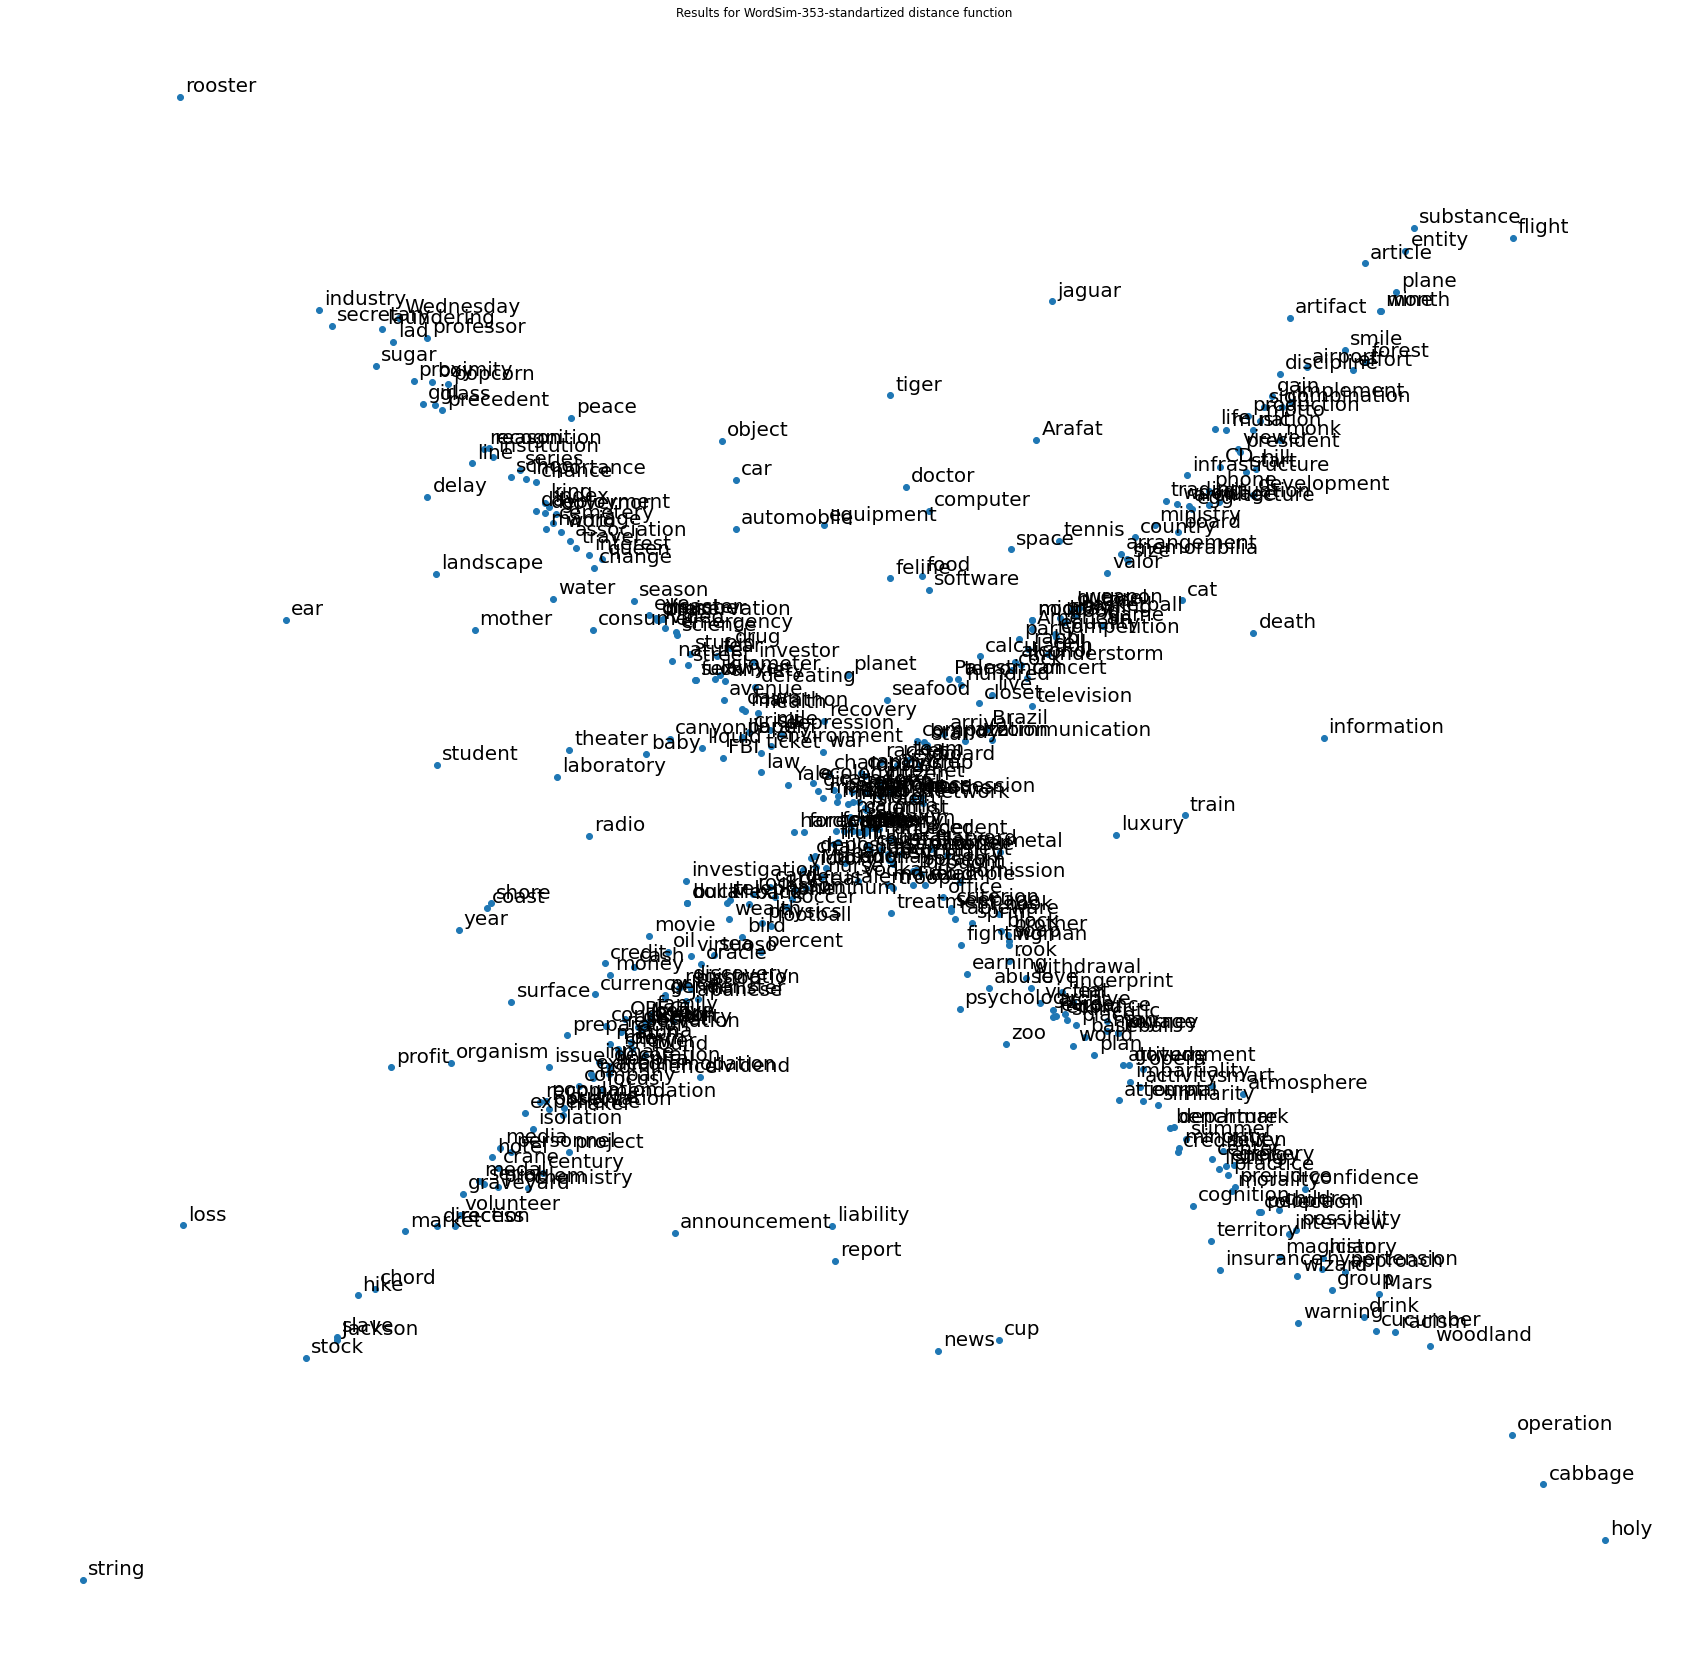

In [629]:
#!g1.1

import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
#figure(figsize=(18, 16), dpi=80)
plt.rcParams["figure.figsize"] = (30,30)

fig, ax = plt.subplots()
a,b,c = zip(*word_coords)
ax.scatter(b, c)

for i, txt in enumerate(a):
    ax.annotate(txt, (b[i], c[i]), fontsize=20, xytext=(5, 5), textcoords='offset points')
    
plt.axis('off')
plt.title(f'Results for {dataset[:-4]} distance function')    
plt.savefig(f'Map_{dataset[:-4]}.png', dpi=100)
plt.show()

## 2 Построение представлений для набора четвёрок

In [630]:
#!g1.1
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import spearmanr

import numpy as np
import copy
from random import sample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [631]:
#!g1.1
class PletNet(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.linear = nn.Linear(inp, out)#, bias=False) # bias is True!
    
    def forward(self, v):
        return self.linear(v)
    
    def inference(self, v):
        with torch.no_grad():
            #return self.linear(torch.from_numpy(v).float())
            return self.linear(v)

In [632]:
#!g1.1

# TripletLoss есть встроенный в torch(может работать быстрее)

class PletLossCos(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, batch_i, batch_j, batch_k, batch_l, size_average=True):
        d_ij = 1 - self.cos(batch_i, batch_j)
        d_kl = 1 - self.cos(batch_k, batch_l)
        losses = F.relu(d_ij - d_kl + self.margin)

        return losses.sum() # можно ли сделать лосс число положительных разностей (дискретный лосс) ?

In [633]:
#!g1.1
class PletLossEuc(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
        self.pdist = torch.nn.PairwiseDistance(p=2, eps=1e-6)
    
    def forward(self, batch_i, batch_j, batch_k, batch_l, size_average=True):
        d_ij = self.pdist(batch_i, batch_j)
        d_kl = self.pdist(batch_k, batch_l)
        losses = F.relu(d_ij - d_kl + self.margin)

        return losses.sum()

In [634]:
#!g1.1

# этот чекер по сути не зависит от экспертных данных
# он считает что в четвёрке первые два объекта должны быть ближе к друг другу чем вторые два
# а так или не так сделал генератор он не знает

def hand_checker_1(vec, gquads, distance='euclidean'):

    counter = 0
    
    for a,b,c,d in gquads:        
        if distance == 'cosine':
            cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
            d_ij = 1 - cos(vec[a], vec[b])
            d_kl = 1 - cos(vec[c], vec[d])
        elif distance == 'euclidean':
            d_ij = (vec[a] - vec[b]).pow(2).sum().sqrt()
            d_kl = (vec[c] - vec[d]).pow(2).sum().sqrt()
            
        if d_ij < d_kl:
            counter += 1

    return counter

In [635]:
#!g1.1

# этому чекеру очень важно, чтобы правило (ближе - более похожи) было согласовано в генераторе и экспертных данных
# если не будет согласовано и например в экспертных данных (больше - более похожи), а в генераторе (меньше - более похожи)
# тогда будет антикорреляция, потому что большие числа станут маленькими

# поскольку более похожие объекты "притягиваются" друг к другу (меньше - более похожи), то экспертные данные переворачиваются (100 - k)
# это expert_reverse=True
# а когда в данных так и есть (меньше - более похожи), то переворачивать эспертные данные не нужно - это expert_reverse = False

def hand_checker_2(m, expert, distance='euclidean', expert_reverse=False):
    
    m_pairs=[]
    exp_pairs=[]

    for i,j,k in expert:
        if i in goods_vocab and j in goods_vocab:
            if distance == 'cosine':
                m_pairs.append(cosine(m[goods_index[i]],
                                      m[goods_index[j]]
                                    ))
            elif distance == 'euclidean':
                 m_pairs.append(euclidean(m[goods_index[i]],
                                          m[goods_index[j]]
                                         ))
            if not expert_reverse:
                exp_pairs.append(k)
            else:
                exp_pairs.append(100. - k)

    #print(len(m_pairs))
    #print(m_pairs[:5], exp_pairs[:5])
    return spearmanr(m_pairs, exp_pairs)[0]

In [636]:
#!g1.1

# this realization is without batches:(
# now with batches:)

def fit_plet(num_epochs, model, loss_fn, opt, vec, a, b, c, d, distance, batch_size=-1, device='cpu'):
    
    quads_count = len(a)
    
    for epoch in tqdm.tqdm(range(num_epochs)):
    
        pred = model(vec)
        
        if batch_size != -1:
            cur_batch_indexes = torch.tensor(sample(range(quads_count), batch_size)).to(device)
            aa = torch.index_select(a, 0, cur_batch_indexes)
            bb = torch.index_select(b, 0, cur_batch_indexes)
            cc = torch.index_select(c, 0, cur_batch_indexes)
            dd = torch.index_select(d, 0, cur_batch_indexes)
        else:
            aa,bb,cc,dd = a,b,c,d            
             
        loss = loss_fn(
                torch.index_select(pred, 0, aa),
                torch.index_select(pred, 0, bb),
                torch.index_select(pred, 0, cc),
                torch.index_select(pred, 0, dd)
               )

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #if epoch % 20000 == 0:
        #    for g in opt.param_groups:
        #        g['lr'] *= 0.1
        
        if loss < 1e-6:
            return model.inference(vec.to(device)).cpu()
        
        if epoch % 1000 == 0:
            #for g in opt.param_groups:
            #    g['lr'] *= 0.1
            #print(hand_checker_1(model.inference(vec.to(device)).cpu(), goods_pool_indexed, distance=distance))
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    return model.inference(vec.to(device)).cpu()###new_vec

## 3 Работа с экспертными данными

In [428]:
#!g1.1
with torch.no_grad():
    torch.cuda.empty_cache()

In [431]:
#!g1.1
import gc
gc.collect()

In [637]:
#!g1.1
datasets = ["MEN-standartized.csv", 
            "SimLex-999-standartized.csv", 
            "WordSim-353-standartized.csv"]

#datasets = ["jaccard-standartized.csv"]
#datasets = ["krasno_triplets.csv"]

results = {}

for dataset in datasets:
    
    results[dataset] = {}
    
    expert = preprop(dataset)    
    expert_quads = prepare_quads(expert, margin=3, reverse=False) #prepare_triplets(expert)
    goods_vocab, goods_index, goods_pool_indexed = prepare_index(expert_quads)
    
    for distance in ['euclidean', 'cosine']:
        
        results[dataset][distance] = []
        
        for vec_size in [100,50,10,5,3,2,1]: #range(300, 0, -50): 
            
            print(f"=== {dataset} === {distance} === {vec_size}")

            #model = PletNet(vec_size).to(device)
            model = PletNet(len(goods_vocab), vec_size).to(device)
            nn.init.xavier_normal_(model.linear.weight.data)
            
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
                        
            if distance == 'cosine':
                plet_loss = PletLossCos(1)
            elif distance == 'euclidean':
                plet_loss = PletLossEuc(1)

            #vec = torch.empty(len(goods_vocab), vec_size)
            #nn.init.xavier_normal_(vec)            
            vec = torch.zeros(len(goods_vocab), len(goods_vocab))
            vec.fill_diagonal_(1)
            # похоже vec нужно загружать на device целиком, потому что в четвёрках могут встретиться любые индексы
            # если только мы не подготовили четвёрки заранее (но тогда их нужно переиндексировать(...))
            
            #print(f'hand_checker_1: {hand_checker_1(vec, goods_pool_indexed, distance)}')
            print(f'hand_checker_2: {hand_checker_2(vec, expert, distance, expert_reverse=True)}')

            #goods_pool_indexed = sample(goods_pool_indexed, 1000000)
            a,b,c,d = list(zip(*goods_pool_indexed))

            if vec_size > 10:
                epochs_num = 3000
            else:
                epochs_num = 20000
                
            fit_plet(epochs_num, model, plet_loss, opt, vec.to(device), #gquads
                       torch.tensor(a).to(device),
                       torch.tensor(b).to(device),
                       torch.tensor(c).to(device),
                       torch.tensor(d).to(device),
                       distance,
                       -1,
                       device                     
                  )
                   
            new_vec = model.inference(vec.to(device)).cpu()
            #print(hand_checker_1(vec, goods_pool_indexed, distance), hand_checker_1(new_vec, goods_pool_indexed, distance), len(goods_pool_indexed))
            print(hand_checker_2(vec, expert, distance, expert_reverse=True), 
                  hand_checker_2(new_vec, expert, distance, expert_reverse=True))
            
            results[dataset][distance].append((vec_size, hand_checker_2(new_vec, expert, distance, expert_reverse=True)))


In [638]:
#!g1.1
results

{'MEN-standartized.csv': {'euclidean': [(100, 0.99840436500678),
   (50, 0.997797843277504),
   (10, 0.9991907009467561),
   (5, 0.9947567973716158),
   (3, 0.971607446212051),
   (2, 0.9218318213384762),
   (1, 0.7415627380277069)],
  'cosine': [(100, 0.962245746500745),
   (50, 0.9622468210842989),
   (10, 0.960908524590554),
   (5, 0.9500202791647423),
   (3, 0.9057850943389941),
   (2, 0.7913110396553552),
   (1, -0.20288162825950343)]},
 'SimLex-999-standartized.csv': {'euclidean': [(100, 0.9927928522013884),
   (50, 0.9917809497413765),
   (10, 0.9888866386169872),
   (5, 0.9881285636405532),
   (3, 0.9878625157646874),
   (2, 0.9847711631903275),
   (1, 0.959571566899476)],
  'cosine': [(100, 0.9520340354640648),
   (50, 0.9544259425869474),
   (10, 0.9531178665999572),
   (5, 0.9521458564708672),
   (3, 0.9508854187755746),
   (2, 0.9307827373152856),
   (1, -0.5160710263347761)]},
 'WordSim-353-standartized.csv': {'euclidean': [(100, 0.990461041489857),
   (50, 0.9859504743743

In [639]:
import json

In [640]:
out_file = open("results.json", "w")
  
json.dump(results, out_file)
  
out_file.close()

In [660]:
results_swap = {}

for distance in ['euclidean', 'cosine']:
    results_swap[distance] = {}
    for dataset in datasets:
        results_swap[distance][dataset]=[(i, abs(j)) for i,j in results[dataset][distance]]#[:-1] # without vec_size==1   

In [661]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [662]:
def create_plot(results, distance='cosine'):
    for i in results[distance]:
        a,b = zip(*results[distance][i])
        plt.plot(a, list(map(abs, b)), label='-'.join(i.split('-')[:-1]))
        plt.legend(loc='upper right')
    plt.xlabel('Embedding size')
    plt.ylabel('Spearman correlation')
    plt.title(f'Results for {distance} distance function')    
    plt.savefig(f'GNMDS_{distance}.png', dpi=100)
    plt.show()

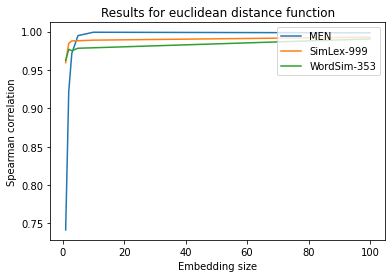

In [663]:
create_plot(results_swap, 'euclidean')

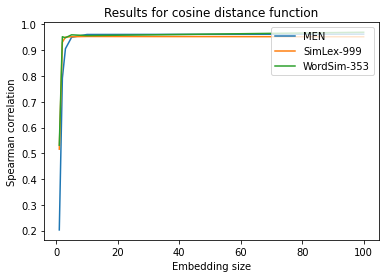

In [664]:
create_plot(results_swap, 'cosine')

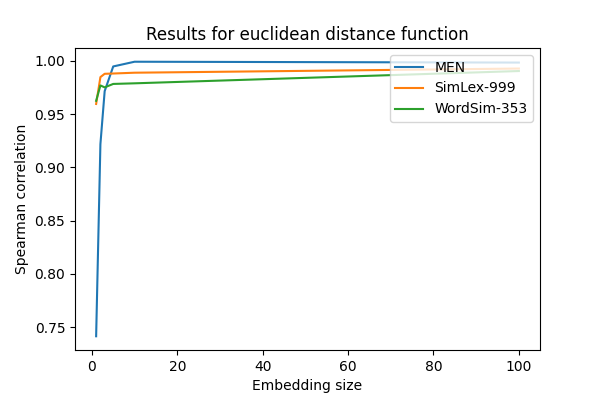

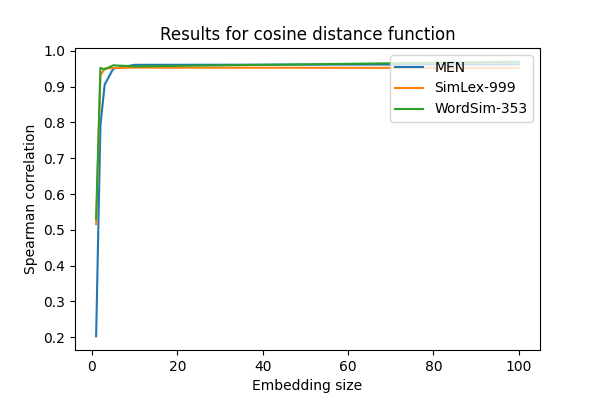

In [665]:
from IPython.display import display, Image

display(Image(filename='GNMDS_euclidean.png'))
display(Image(filename='GNMDS_cosine.png'))